In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'nearest'

# RANSAC

From WikiPedia:

> Random sample consensus (RANSAC) is an iterative method to estimate
> parameters of a mathematical model from a set of observed data which
> contains outliers. Therefore, it also can be interpreted as an
> outlier detection method.

[Gallery example](http://scikit-image.org/docs/dev/auto_examples/plot_matching.html)

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from skimage.measure import ransac

Let's set up some random data points:

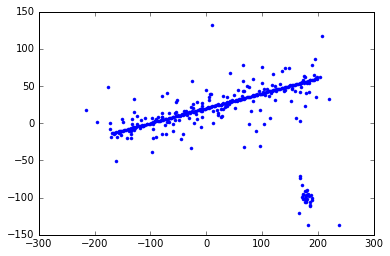

In [3]:
np.random.seed(seed=1)

# generate coordinates of line
x = np.arange(-200, 200)
y = 0.2 * x + 20
data = np.column_stack([x, y])

# add faulty data
faulty = np.array(30 * [(180., -100)])
faulty += 5 * np.random.normal(size=faulty.shape)
data[:faulty.shape[0]] = faulty

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape)
data += 0.5 * noise
data[::2] += 5 * noise[::2]
data[::4] += 20 * noise[::4]

plt.plot(data[:, 0], data[:, 1], '.');

Now, fit a line to the data.  We start with our model:

$$\mathbf{y} = m \mathbf{x} + c$$

Or, in matrix notation:

$$\mathbf{y} = \left[ \begin{array}{c} \vdots \\ \mathbf{x} \\ \vdots \end{array}
                     \ \begin{array}{c} \vdots \\ \mathbf{1} \\ \vdots \end{array} \right]
                     \left[ \begin{array}{c} m \\ c \end{array} \right]
                     = X \mathbf{p}$$

Since we have an over-determined system, we use least squares to solve:

In [4]:
x = data[:, 0]
y = data[:, 1]

X = np.column_stack((x, np.ones_like(x)))

p, _, _, _ = np.linalg.lstsq(X, y)
p

array([  0.04829453,  12.45526055])

With those parameters in hand, let's plot the resulting line:

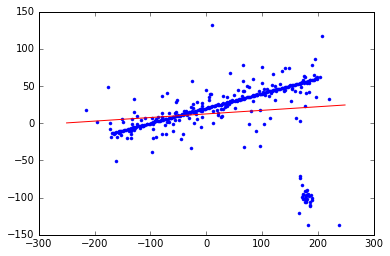

In [5]:
m, c = p
plt.plot(x, y, 'b.')

xx = np.arange(-250, 250)
plt.plot(xx, m * xx + c, 'r-');

Scikit-image provides an N-dimensional LineModel object that encapsulates the above:

In [6]:
from skimage.measure import ransac, LineModelND, CircleModel

model = LineModelND()
model.estimate(data)
model.params

(array([ 27.3093349 ,  13.77415203]), array([-0.99847184, -0.05526279]))

Instead of ``m`` and ``c``, it parameterizes the line by ``origin``
and ``direction`` --- much safer when dealing with vertical lines,
e.g.!

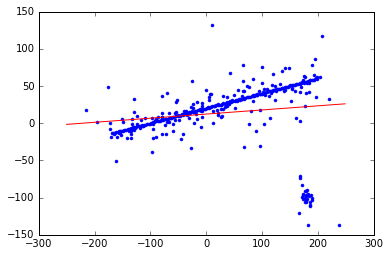

In [7]:
origin, direction = model.params
plt.plot(x, y, 'b.')
plt.plot(xx, model.predict_y(xx), 'r-');

Now, we robustly fit the line using inlier data selecte with the RANSAC algorithm:

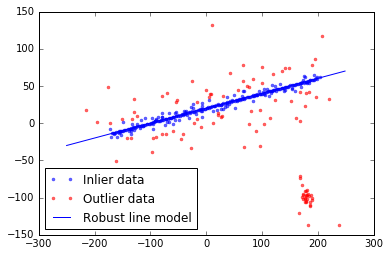

In [8]:
model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                               residual_threshold=10, max_trials=1000)
outliers = (inliers == False)

yy = model_robust.predict_y(xx)

fig, ax = plt.subplots()

ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(data[outliers, 0], data[outliers, 1], '.r', alpha=0.6, label='Outlier data')
ax.plot(xx, yy, '-b', label='Robust line model')

plt.legend(loc='lower left')
plt.show()

## Exercise: Going interplanetary

The sun is one of the most spherical objects in our solar system.
According to an [article in Scientific American](http://www.scientificamerican.com/gallery/well-rounded-sun-stays-nearly-spherical-even-when-it-freaks-out/):

> Earth's closest star is one of the roundest objects humans have
> measured. If you shrank the sun down to beach ball size, the
> difference between its north-south and the east-west diameters would
> be thinner than the width of a human hair, says Jeffery Kuhn, a
> physicist and solar researcher at the University of Hawaii at
> Manoa. "Not only is it very round, but it's too round," he adds. The
> sun is more spherical and more invariable than theories predict.

If the sun is spherical, we should be able to fit a circle to a 2D
slice of it!  Your task is to do just that, using RANSAC and scikit-image's CircleModel.

Let's start by loading an example image:

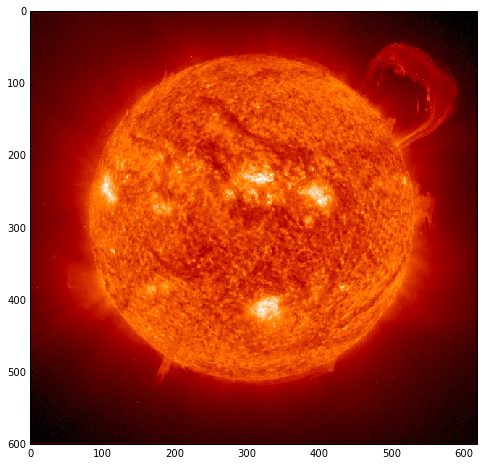

In [9]:
from skimage import io

image = io.imread('/Volumes/Data/Other_git/skimage-tutorials/images/superprom_prev.jpg')

f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image);

In this specific image, we got a bit more than we bargained for in the
form of magnificently large solar flares.  Let's see if some *canny
edge detection* will help isolate the sun's boundaries.

In [17]:
from skimage import feature, color, draw

# Step 1: convert the image from color to gray, using `color.rgb2gray`

image1 = color.rgb2gray(image)

# Step 2: do edge detection on the image, using `feature.canny`.  Play around with the `sigma`
# parameter until you get a reasonable set of edges.

edges1 = feature.canny(image1, sigma=0.055)
coords1 = np.column_stack(np.nonzero(edges1))

model1, inliers1 = ransac(coords1, CircleModel,
                                min_samples=3, residual_threshold=1,
                                max_trials=1000)

print(model1.params)

[ 300.80088126  303.08150824  207.18530068]


In [11]:
#edges1 = feature.canny(image1, sigma=2)
#coords1 = np.column_stack(np.nonzero(edges1))

#model1, inliers1 = ransac(coords1, CircleModel,
#                                min_samples=3, residual_threshold=2,
#                                max_trials=500)

#print(model1.params)

[ 283.67847238  309.625484    223.57022336]


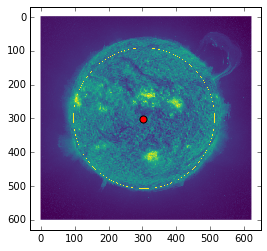

In [18]:
rr1, cc1 = draw.circle_perimeter(int(model1.params[0]),
                               int(model1.params[1]),
                               int(model1.params[2]),
                               shape=image1.shape)

image1[rr1, cc1] = 1

plt.imshow(image1, vmax=1e0, cmap='viridis')
plt.scatter(model1.params[1], model1.params[0], s=50, c='red')
#plt.axis('off')
#plt.savefig('flame_center.png', bbox_inches='tight')
plt.show()

The edges look good, but there's a lot going on inside the sun.  We
use RANSAC to fit a robust circle model.

In [19]:
from skimage.measure import CircleModel

points = ...    # Let points be an array with coordinate
#positions of edge pixels found above, shape (2, N)

model_robust, inliers = ransac(...)

TypeError: ransac() missing 3 required positional arguments: 'model_class', 'min_samples', and 'residual_threshold'

The parameters of the circle are center x, y and radius:

In [20]:
model_robust.params

(array([ 13.14633425,  22.78290415]), array([ 0.98048717,  0.19658307]))

Let's visualize the results, drawing a circle on the sun, and also
highlighting inlier vs outlier edge pixels:

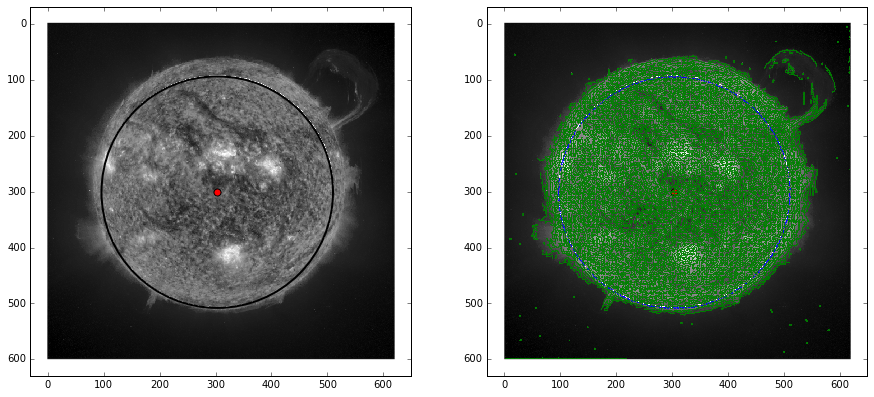

In [21]:
from skimage import draw

cy, cx, r = model1.params

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 8))

ax0.imshow(image1)
ax0.scatter(model1.params[1], model1.params[0], s=50, c='red')
ax1.imshow(image1)

ax1.plot(coords1[inliers1, 1], coords1[inliers1, 0], 'b.', markersize=1)
ax1.plot(coords1[~inliers1, 1], coords1[~inliers1, 0], 'g.', markersize=1)
ax1.scatter(model1.params[1], model1.params[0], s=50, c='red')
ax1.axis('image')

circle = plt.Circle((cx, cy), radius=r, facecolor='none', linewidth=2)
ax0.add_patch(circle);

## Exercise: CardShark

Your small start-up, CardShark, that you run from your garage over nights and
evenings, takes photos of credit cards and turns them into machine
readable information.

The first step is to identify where in a photo the credit card is
located.

1. Load the photo `../images/credit_card.jpg`
2. Using RANSAC and LineModelND shown above, find the first most
   prominent edge of the card
3. Remove the edge points belonging to the most prominent edge, and
   repeat the process to find the second, third, and fourth

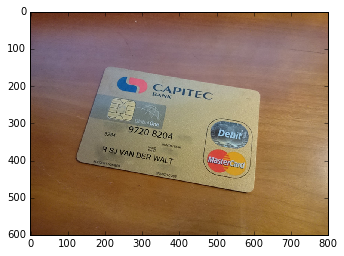

In [22]:
f, ax = plt.subplots()

image = io.imread('/Volumes/Data/Other_git/skimage-tutorials/images/credit_card.jpg')
ax.imshow(image);

In [23]:
data1 = color.rgb2gray(image)

# Step 2: do edge detection on the image, using `feature.canny`.  Play around with the `sigma`
# parameter until you get a reasonable set of edges.

edges1 = feature.canny(data1, sigma=0.045)
coords1 = np.column_stack(np.nonzero(edges1))

model_card, inliers_c = ransac(data1, LineModelND, min_samples=2,
                               residual_threshold=10, max_trials=1000)
outliers = (inliers_c == False)



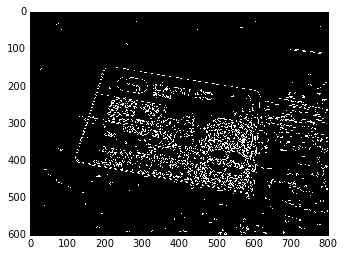

In [25]:
plt.figure()
plt.imshow(edges1)
plt.imshow(data1, cmap="viridis")
plt.imshow(edges1, cmap="gray")
plt.show()

In [26]:
model_c = LineModelND()
model.estimate(data1)
model.params

(array([ 0.29705232,  0.29847148,  0.29938405,  0.29963986,  0.30049082,
         0.30129263,  0.30193233,  0.30253374,  0.30393932,  0.30405329,
         0.30458017,  0.30526872,  0.3059427 ,  0.30671377,  0.3075891 ,
         0.30832349,  0.30842361,  0.3086403 ,  0.30939021,  0.31039951,
         0.31140215,  0.31194097,  0.31248943,  0.31330138,  0.31382532,
         0.31401706,  0.31430006,  0.3147595 ,  0.31576616,  0.31661832,
         0.31702806,  0.31740111,  0.31872688,  0.31924557,  0.32036269,
         0.32131168,  0.32143938,  0.32179249,  0.32272658,  0.32352071,
         0.32341248,  0.3229078 ,  0.32311037,  0.32399704,  0.32517417,
         0.3258862 ,  0.32620996,  0.3264617 ,  0.32721922,  0.32808007,
         0.32910573,  0.33000548,  0.33047   ,  0.33113822,  0.33181672,
         0.3326934 ,  0.33295037,  0.3333445 ,  0.33394407,  0.33469722,
         0.33515497,  0.33536163,  0.33629007,  0.33751078,  0.33820903,
         0.33916519,  0.33936019,  0.33926487,  0.3

In [27]:
edges_c = feature.canny(color.rgb2gray(image), sigma=3)
edge_pts = np.array(np.nonzero(edges_c), dtype=float).T
edge_pts_xy = edge_pts[:, ::-1]

/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:6: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


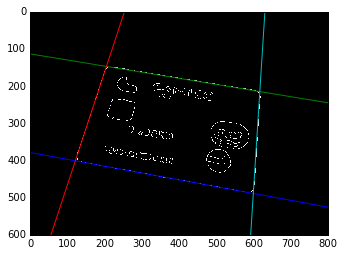

In [28]:
for i in range(4):
    model_robust, inliers = ransac(edge_pts_xy, LineModelND, min_samples=2,
                                   residual_threshold=1, max_trials=1000)
    x = np.arange(800)
    plt.plot(x, model_robust.predict_y(x))
    edge_pts_xy = edge_pts_xy[-inliers]
    
plt.imshow(edges_c);